In [2]:
import os
import re
from collections import defaultdict

# ============================================================
# 正则表达式：epoch summary, valid loss/acc
# ============================================================

# 训练 epoch 的 dyn_dyn_loss/dyn_sta_loss/tot_dyn_loss
re_epoch = re.compile(
    r"epoch\s+(\d+)\s+summary:\s*"
    r"dyn_dyn_loss\s*:\s*([\d\.Ee+-]+),\s*"
    r"dyn_sta_loss\s*:\s*([\d\.Ee+-]+),\s*"
    r"tot_dyn_loss\s*:\s*([\d\.Ee+-]+),"
)

# valid 信息
re_valid = re.compile(
    r"valid loss:\s*([\d\.Ee+-]+),\s*valid acc:\s*([\d\.Ee+-]+)"
)

# ============================================================
# 解析新命名格式：
# N${N}_vocab${N_vocab}_ps${pos_ratio}_ratio${ratio_dyn}.log
# ============================================================

def parse_filename(fname):
    m = re.match(
        r"N(\d+)_vocab(\d+)_ps([0-9\.]+)_ratio([0-9\.]+)\.log",
        fname
    )
    if not m:
        return None

    return {
        "N": int(m.group(1)),
        "N_vocab": int(m.group(2)),
        "pos_ratio": m.group(3),     # 先保留字符串形式
        "ratio_dyn": m.group(4)
    }


# ============================================================
# 解析单个 log 文件：全部 epoch、valid_loss/acc
# ============================================================

def parse_log(path):
    dyn_dyn_loss = []
    dyn_sta_loss = []
    tot_dyn_loss = []

    valid_losses = []
    valid_accs = []

    with open(path, "r", encoding="utf-8") as f:
        for line in f:

            # -------- epoch summary --------
            m = re_epoch.search(line)
            if m:
                dyn_dyn_loss.append(float(m.group(2)))
                dyn_sta_loss.append(float(m.group(3)))
                tot_dyn_loss.append(float(m.group(4)))
                continue

            # -------- valid info --------
            m = re_valid.search(line)
            if m:
                valid_losses.append(float(m.group(1)))
                valid_accs.append(float(m.group(2)))
                continue

    return {
        "dyn_dyn_loss": dyn_dyn_loss,
        "dyn_sta_loss": dyn_sta_loss,
        "tot_dyn_loss": tot_dyn_loss,

        "valid_min": min(valid_losses) if len(valid_losses) > 0 else None,
        "valid_max_acc": max(valid_accs) if len(valid_accs) > 0 else None
    }


# ============================================================
# 检查是否为本次 .sh 生成的日志（保证一致性）
# ------------------------------------------------------------
# 必须同时匹配以下参数：
#   N in {2048,8192,32768}
#   N_vocab in {384,512,768}
#   pos_ratio in {0.125,0.5,0.875}
#   ratio_dyn in {0.00,0.01,0.02,...}
# ============================================================

valid_N = {2048, 8192, 32768}
valid_N_vocab = {384, 512, 768}
valid_pos_ratio = {"0.125", "0.5", "0.875"}
valid_ratio_dyn = {
    "0.00","0.01","0.02","0.04","0.08","0.16","0.32",
    "0.64","0.80","0.95","0.99","1.00"
}


def check_from_sh(info):
    if info["N"] not in valid_N:
        return False
    if info["N_vocab"] not in valid_N_vocab:
        return False
    if info["pos_ratio"] not in valid_pos_ratio:
        return False
    if info["ratio_dyn"] not in valid_ratio_dyn:
        return False
    return True


# ============================================================
# 主函数：加载目录下全部日志
# ============================================================

def load_all_logs(log_root):
    logs = []

    for f in os.listdir(log_root):
        if not f.endswith(".log"):
            continue

        info = parse_filename(f)
        if info is None:
            continue

        # 是否来源于你的 .sh 脚本
        info["valid_from_sh"] = check_from_sh(info)

        # 解析 log 内容
        full_path = os.path.join(log_root, f)
        metrics = parse_log(full_path)

        item = {
            **info,
            **metrics,
            "path": full_path
        }
        logs.append(item)

    return logs


# ============================================================
# 运行：加载所有日志
# ============================================================

log_dir = "."         # ★★★ 你的日志目录
logs = load_all_logs(log_dir)

print(f"Loaded {len(logs)} log files.")

# 展示前三个
for x in logs[:3]:
    print(x)


Loaded 324 log files.
{'N': 8192, 'N_vocab': 384, 'pos_ratio': '0.5', 'ratio_dyn': '1.00', 'valid_from_sh': True, 'dyn_dyn_loss': [0.08601, 0.08494, 0.07905, 0.06345, 0.04929, 0.04034, 0.03441, 0.03028, 0.02723, 0.02491, 0.02323, 0.02187, 0.02081, 0.02002, 0.0194, 0.01894, 0.01845, 0.01807, 0.01778, 0.01746, 0.01718, 0.01697, 0.01686, 0.01677, 0.01657, 0.01645, 0.01643, 0.01629, 0.01614, 0.01612, 0.01596, 0.0159, 0.01585, 0.01581, 0.01573, 0.01567, 0.01564, 0.01558, 0.01554, 0.0155, 0.01547, 0.01543, 0.01536, 0.01538, 0.01539, 0.01534, 0.01532, 0.01529, 0.0153, 0.01528, 0.01523, 0.01518, 0.01518, 0.01512, 0.01515, 0.0151, 0.01503, 0.01507, 0.01502, 0.01504], 'dyn_sta_loss': [7.39971, 7.3938, 7.38307, 7.40817, 7.46342, 7.51589, 7.51825, 7.52281, 7.5188, 7.51117, 7.50285, 7.49438, 7.50022, 7.50145, 7.49557, 7.49123, 7.47792, 7.47108, 7.46925, 7.46654, 7.46249, 7.45716, 7.45073, 7.45628, 7.46901, 7.44937, 7.45206, 7.44769, 7.43124, 7.43877, 7.43791, 7.4383, 7.44052, 7.44188, 7.44312, 7.43

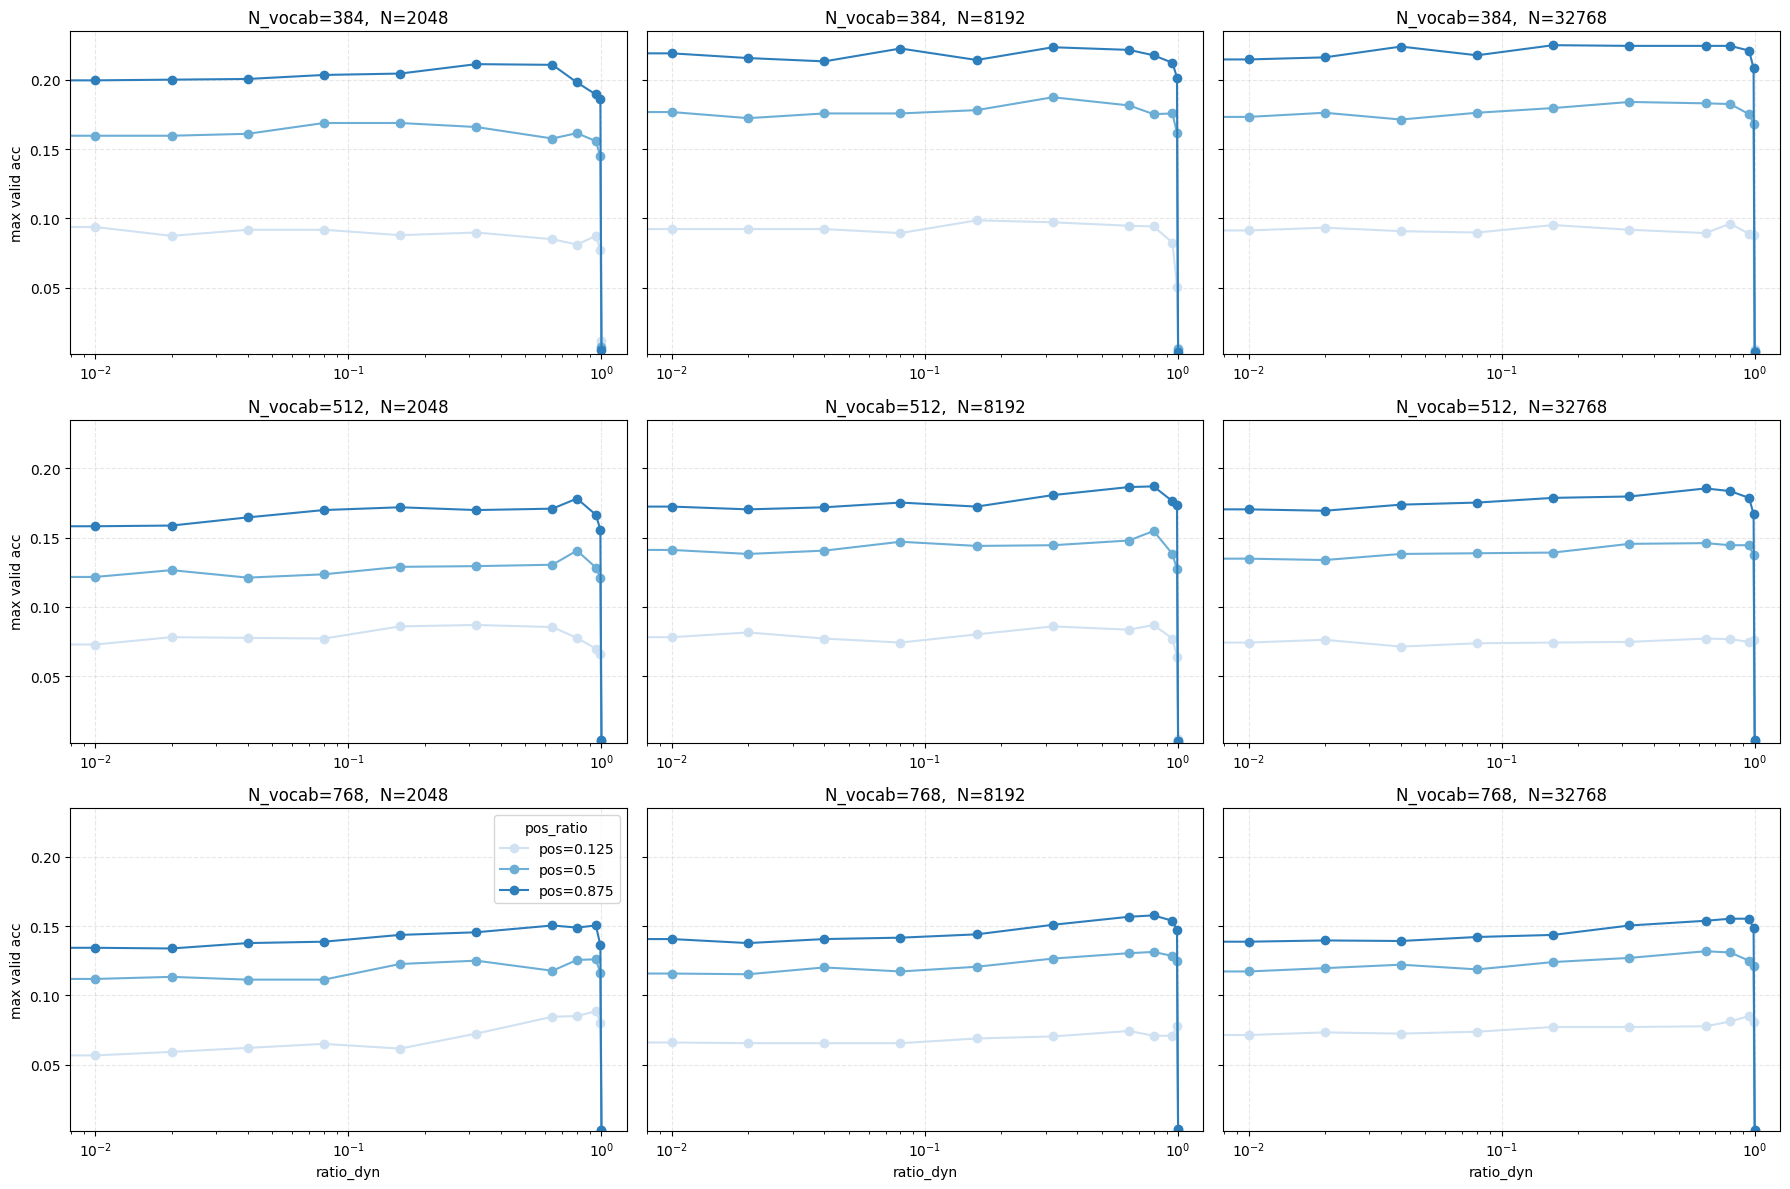

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# ---------------------------------------------------------
# 抽取所有 max_valid_acc，按 N_vocab → N → pos_ratio → ratio_dyn
# ---------------------------------------------------------

# 结构：acc_map[N_vocab][N][pos_ratio][ratio_dyn] = max valid acc
acc_map = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for item in logs:
    if not item["valid_from_sh"]:
        continue

    N = item["N"]
    N_vocab = item["N_vocab"]
    ps = item["pos_ratio"]
    r = item["ratio_dyn"]
    acc = item["valid_max_acc"]

    if acc is None:
        continue

    # ratio_dyn string 转 float，用于画图排序
    f_r = float(r)

    if r not in acc_map[N_vocab][N][ps]:
        acc_map[N_vocab][N][ps][f_r] = acc
    else:
        acc_map[N_vocab][N][ps][f_r] = max(acc_map[N_vocab][N][ps][f_r], acc)

# ---------------------------------------------------------
# 排序好的参数列表
# ---------------------------------------------------------

N_list = [2048, 8192, 32768]
N_vocab_list = [384, 512, 768]
pos_ratio_list = ["0.125", "0.5", "0.875"]

ratio_dyn_all = sorted({
    float(item["ratio_dyn"])
    for item in logs if item["valid_from_sh"]
})

# 颜色
cmap = plt.get_cmap("Blues_r")
pos_colors = {
    "0.125": cmap(0.8),
    "0.5":   cmap(0.5),
    "0.875": cmap(0.3)
}

# ---------------------------------------------------------
# 统一 Y 轴范围
# ---------------------------------------------------------

all_acc_values = []
for N_vocab in acc_map:
    for N in acc_map[N_vocab]:
        for ps in acc_map[N_vocab][N]:
            all_acc_values += list(acc_map[N_vocab][N][ps].values())

if len(all_acc_values) > 0:
    y_min = min(all_acc_values)
    y_max = max(all_acc_values)
else:
    y_min, y_max = 0, 1

# ---------------------------------------------------------
# 绘图：3×3 (N_vocab 行 × N 列)
# ---------------------------------------------------------

fig, axes = plt.subplots(
    nrows=3, ncols=3,
    figsize=(18, 12),
    sharey=True
)

for i, N_vocab in enumerate(N_vocab_list):
    for j, N in enumerate(N_list):

        ax = axes[i, j]

        # 某张图仅画 pos_ratio 的三条线
        for ps in pos_ratio_list:
            sub = acc_map[N_vocab][N].get(ps, {})

            xs = sorted(sub.keys())
            ys = [sub[x] for x in xs]

            if len(xs) > 0:
                ax.plot(xs, ys, marker="o", color=pos_colors[ps], label=f"pos={ps}")

        ax.set_title(f"N_vocab={N_vocab},  N={N}")
        ax.grid(True, linestyle="--", alpha=0.3)

        ax.set_ylim(y_min, y_max+0.01)
        ax.set_xscale("log", base=10)

        if i == 2:
            ax.set_xlabel("ratio_dyn")
        if j == 0:
            ax.set_ylabel("max valid acc")

# 最左下角画 legend
axes[2, 0].legend(title="pos_ratio")

plt.tight_layout()
plt.show()


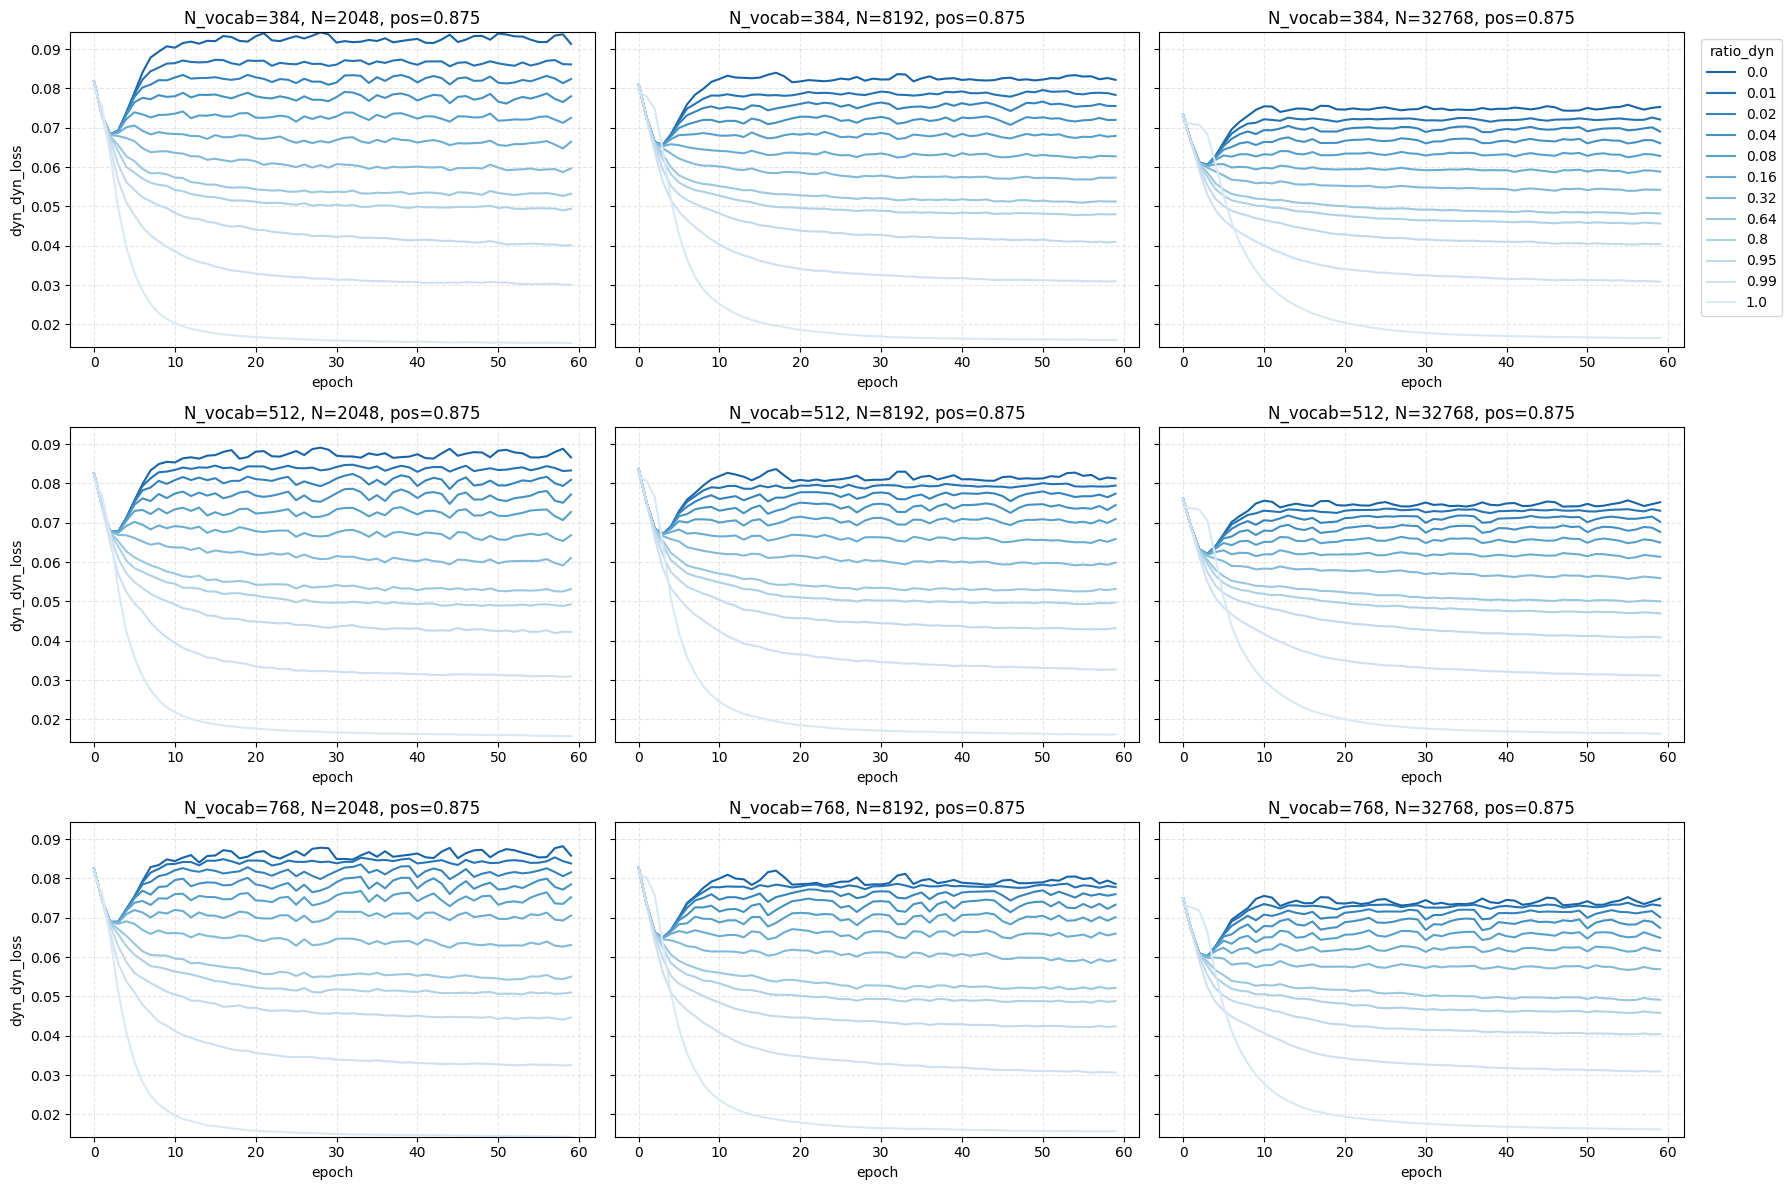

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# 你想画哪一个 pos_ratio？
# ---------------------------------------------------------
target_pos_ratio = "0.875"       # ★★★ 你可以修改为 "0.125" 或 "0.5"

# ---------------------------------------------------------
# 参数列表
# ---------------------------------------------------------
N_list = [2048, 8192, 32768]
N_vocab_list = [384, 512, 768]

# 取日志中出现的 ratio_dyn（排序）
ratio_dyn_all = sorted({
    float(item["ratio_dyn"])
    for item in logs if item["valid_from_sh"]
})

# 颜色渐变：Blues_r 浅→深
cmap = plt.get_cmap("Blues_r")
colors = [cmap(x) for x in np.linspace(0.2, 0.85, len(ratio_dyn_all))]

# ---------------------------------------------------------
# 绘制 3×3 图
# ---------------------------------------------------------
fig, axes = plt.subplots(
    nrows=3, ncols=3,
    figsize=(18, 12),
    sharey=True
)

# ---------------------------------------------------------
# 构建映射：给定 (N_vocab, N, pos_ratio, ratio_dyn) 找 dyn_dyn_loss
# ---------------------------------------------------------
dyn_map = {}   # dyn_map[(N_vocab, N, ps, ratio)] = dyn_dyn_loss(list)

for item in logs:
    if not item["valid_from_sh"]:
        continue

    N = item["N"]
    N_vocab = item["N_vocab"]
    ps = item["pos_ratio"]
    ratio = float(item["ratio_dyn"])

    key = (N_vocab, N, ps, ratio)
    dyn_map[key] = item["dyn_dyn_loss"]

# ---------------------------------------------------------
# 统一 y 轴范围
# ---------------------------------------------------------
all_ys = []
for key, ys in dyn_map.items():
    if key[2] != target_pos_ratio:
        continue
    all_ys += ys

if len(all_ys) > 0:
    y_min = min(all_ys)
    y_max = max(all_ys)
else:
    y_min, y_max = 0, 1

# ---------------------------------------------------------
# 实际绘制
# ---------------------------------------------------------
for i, N_vocab in enumerate(N_vocab_list):
    for j, N in enumerate(N_list):

        ax = axes[i, j]

        # 对每个 ratio_dyn 画一条 dyn_dyn_loss 曲线
        for ratio, color in zip(ratio_dyn_all, colors):

            key = (N_vocab, N, target_pos_ratio, ratio)

            if key not in dyn_map:
                continue

            ys = dyn_map[key]
            xs = np.arange(len(ys))

            ax.plot(xs, ys, color=color, label=f"r={ratio}")

        ax.set_title(f"N_vocab={N_vocab}, N={N}, pos={target_pos_ratio}")
        ax.set_xlabel("epoch")
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.set_ylim(y_min, y_max)

        if j == 0:
            ax.set_ylabel("dyn_dyn_loss")

# 最右上角加 legend（只画一次）
axes[0, 2].legend(
    [f"{r}" for r in ratio_dyn_all],
    title="ratio_dyn",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()
